# Points of Dispense - Template
Maxwell Kennady, Nora Murray, Elizabeth Speigle

In [40]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Optimization

Read in data from ...

In [41]:
distances = pd.read_csv('data/OD_Pairs_Distances.csv')
population = pd.read_excel('data/BG_master.xlsx')
bg_included = pd.read_csv('data/bg_pop_included.csv')
pod_data = pd.read_csv('data/POD_ids.csv')

In [42]:
pod_data['capacity_50'] = pod_data['student_pop'] * 50

In [43]:
dist_miles = distances.pivot(index='block_group', columns='pod_id', values='Miles')
dist_time = distances.pivot(index='block_group', columns='pod_id', values='TravelTime')

In [44]:
dist = dist_miles.values                     # can change to dist_time
N = population['population'].values          # can change to num_hhs for households
prop = bg_included['all_included'].values    # can change to random_included or other column
cap = pod_data['capacity_50'].values         # can change to other values of capacity

Create indices for block groups and PODs

In [45]:
blocks = range(len(N))
pods = range(len(dist[0]))

Initialize model for POD locations

In [46]:
m = gp.Model('POD_locations')

Add decision variables x[i] for whether a POD is opened and y[i,j] for whether POD i serves block group j

In [47]:
x = m.addVars(pods, vtype=GRB.BINARY, name='x')
y = m.addVars(blocks, pods, vtype=GRB.BINARY, name='x')

Set up objective function to minimize total distance across the population

In [48]:
obj = gp.quicksum(dist[j,i] * x[i] * y[j, i] * N[j] * prop[j] 
                  for j in blocks for i in pods)

Vary number of PODs to open

In [60]:
pods_open = range(10, 48)
pods_open_results = {}

In [61]:
for i in pods_open: 
    ### Set objective
    m.setObjective(obj, GRB.MINIMIZE)
    
    ### Add constraints
    #  y[i,j] can only be 1 if x[i] is also 1, meaning POD i is opened
    m.addConstrs((y[j, i] <= x[i] for i in pods for j in blocks), name='y_if_x')
    
    # each block group must be assigned one shelter
    m.addConstrs((gp.quicksum(y[j, i] for i in pods) == 1
             for j in blocks), name='all_blocks_assigned')
    
    # number of PODs opened must be less than num_pods
    m.addConstr((gp.quicksum(x[i] for i in pods) <= i), name='pods_opened')
    
    # capacity at each pod
    # m.addConstrs((gp.quicksum(N[j] * x[i] * y[j, i] for j in blocks) <= cap[i]
    #        for i in pods), name='Capacity')
    
    ### Optimize
    print('Solving for:', i, 'PODs')
    m.optimize()
    pods_open_results[i] = {}
    pods_open_results[i]['obj'] = obj.getValue()
    
    ### Analysis
    block_pod_list = [[j,i] for j in blocks for i in pods if y[j, i].x==1]
    pods_open_results[i]['results'] = block_pod_list

Solving for: 10 PODs
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 1689632 rows, 51747 columns and 4964704 nonzeros
Model fingerprint: 0x20ebb7b7
Model has 51324 quadratic objective terms
Variable types: 0 continuous, 51747 integer (51747 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+01, 3e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]

Loaded MIP start from previous solve with objective 4.99991e+06

Presolve removed 1636831 rows and 0 columns (presolve time = 5s) ...
Presolve removed 1636831 rows and 0 columns
Presolve time: 7.66s
Presolved: 104125 rows, 103071 columns, 309119 nonzeros
Variable types: 0 continuous, 103071 integer (103071 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5319018e+07   1.1000

In [62]:
pods_open_results.keys()

dict_keys([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46])

### Analysis

In [33]:
dist_min_total = [N[j] * [dist[j,i]] for [j,i] in block_pod_list]
dist_min_total_flat = [item for sublist in dist_min_total for item in sublist]

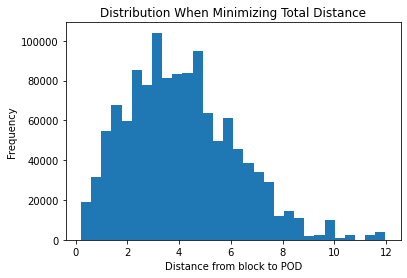

In [34]:
plt.hist(dist_min_total_flat, bins=30)
plt.title('Distribution When Minimizing Total Distance')
plt.xlabel('Distance from block to POD')
plt.ylabel('Frequency')
plt.show()

In [35]:
capacity_pod_all = [[N[j], i] for [j,i] in block_pod_list]

In [36]:
capacity_pod = {}
for [N, i] in capacity_pod_all:
    if i not in capacity_pod:
        capacity_pod[i] = N
    else:
        capacity_pod[i] += N

In [37]:
max(capacity_pod.values())

223303

In [38]:
min(capacity_pod.values())

34742

In [39]:
capacity_pod

{27: 143791,
 29: 223303,
 4: 156664,
 22: 208556,
 17: 34742,
 16: 71442,
 23: 65189,
 26: 110294,
 9: 90924,
 19: 120656}